In [33]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import random

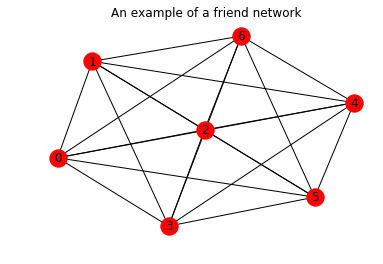

In [34]:
friend_group_count = 3
friends_per_group = 7
max_interminglings = 3

class Person(object):
    def __init__(self, id_number):
        self.id_number = id_number
    def __str__(self):
        return str(self.id_number)

friend_groups = list()
friend_networks = list()

for group_number in range(friend_group_count):
    """
    Initialize groups of friends
    """
    
    # Create a list of friends
    lower_fence = group_number * friends_per_group
    upper_fence = lower_fence + friends_per_group
    friend_group = [Person(id_number) for id_number in range(lower_fence, upper_fence)]
    friend_groups.append(friend_group)
    
    # Create a network from the list
    friend_network = nx.Graph()
    friend_network.add_nodes_from(friend_group)
    friend_networks.append(friend_network)
    
    # Join all the members of the network together
    for friend in friend_network:
        for other_friend in friend_network:
            if other_friend is not friend:
                friend_network.add_edge(friend, other_friend)

plt.title('An example of a friend network')
nx.draw(friend_networks[0], with_labels=True)

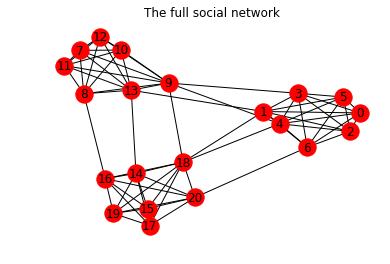

In [47]:
social_network = nx.Graph()
for friend_network in friend_networks:
    social_network.add_nodes_from(friend_network)
    social_network.add_edges_from(friend_network.edges())

for combination in itertools.combinations(friend_networks, r=2):
    fst = list(combination[0].nodes())
    snd = list(combination[1].nodes())
    for _ in range(max_interminglings):
        partner_fst = random.choice(fst)
        partner_snd = random.choice(snd)
        social_network.add_edge(partner_fst, partner_snd)

plt.title('The full social network')
nx.draw(social_network, with_labels=True)